In [1]:
import sys 

sys.path.insert(0, '..')

In [25]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

In [26]:
image_path = './'

celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Train set: 162770
Validation set: 19867
Test set: 19962


In [27]:
# transformers to augment data to produce more trainable data

get_smile = lambda attr: attr[31]

transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

In [28]:
torch.manual_seed(1)

celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False, transform=transform_train, target_transform=get_smile)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False, transform=transform_test, target_transform=get_smile)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False, transform=transform_test, target_transform=get_smile)

data_loader = DataLoader(celeba_train_dataset, batch_size=2)

In [29]:

# train on small dataset as a challenge
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(20000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000)) 

In [30]:
batch_size = 32

train_dl = DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

In [31]:
model = nn.Sequential()

model.add_module(name='conv1', module=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module(name='relu1', module=nn.ReLU())
model.add_module(name='pool1', module=nn.MaxPool2d(kernel_size=2))
model.add_module(name='dropout1', module=nn.Dropout(p=.5))

model.add_module(name='conv2', module=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module(name='relu2', module=nn.ReLU())        
model.add_module(name='pool2', module=nn.MaxPool2d(kernel_size=2))   
model.add_module(name='dropout2', module=nn.Dropout(p=0.5)) 

model.add_module(name='conv3', module=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module(name='relu3', module=nn.ReLU())        
model.add_module(name='pool3', module=nn.MaxPool2d(kernel_size=2))   

model.add_module(name='conv4', module=nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module(name='relu4', module=nn.ReLU())  

In [32]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) 
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 3, 64, 64))
model(x).shape


torch.Size([4, 256])

In [33]:
model.add_module(name='fc', module=nn.Linear(256, 1))
model.add_module(name='sigmoid', module=nn.Sigmoid())

In [34]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [35]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [36]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

def train(model, num_epochs, train_dl, valid_dl):
    accuracy_hist_train = [0.0] * num_epochs
    accuracy_hist_valid = [0.0] * num_epochs

    for epoch in range(num_epochs):
        model.train() # put in training mode
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            is_correct = ((pred >= .5).float() == y_batch).sum()
            accuracy_hist_train[epoch] += is_correct.item()
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())

                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch}, training accuracy: {accuracy_hist_train[epoch]:.4f}, validation accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return accuracy_hist_train, accuracy_hist_valid

num_epochs = 50
accuracy_hist_train, accuracy_hist_valid = train(model, num_epochs, train_dl, valid_dl) 

Epoch 0, training accuracy: 0.5183, validation accuracy: 0.5140
Epoch 1, training accuracy: 0.5255, validation accuracy: 0.5630
Epoch 2, training accuracy: 0.5732, validation accuracy: 0.5880
Epoch 3, training accuracy: 0.6106, validation accuracy: 0.6140
Epoch 4, training accuracy: 0.6271, validation accuracy: 0.6070
Epoch 5, training accuracy: 0.6490, validation accuracy: 0.6170
Epoch 6, training accuracy: 0.6692, validation accuracy: 0.6160
Epoch 7, training accuracy: 0.6760, validation accuracy: 0.6690
Epoch 8, training accuracy: 0.6896, validation accuracy: 0.6670
Epoch 9, training accuracy: 0.6984, validation accuracy: 0.6860
Epoch 10, training accuracy: 0.7243, validation accuracy: 0.7590
Epoch 11, training accuracy: 0.7550, validation accuracy: 0.7540
Epoch 12, training accuracy: 0.7761, validation accuracy: 0.7940
Epoch 13, training accuracy: 0.8005, validation accuracy: 0.8240
Epoch 14, training accuracy: 0.8187, validation accuracy: 0.8310
Epoch 15, training accuracy: 0.8288

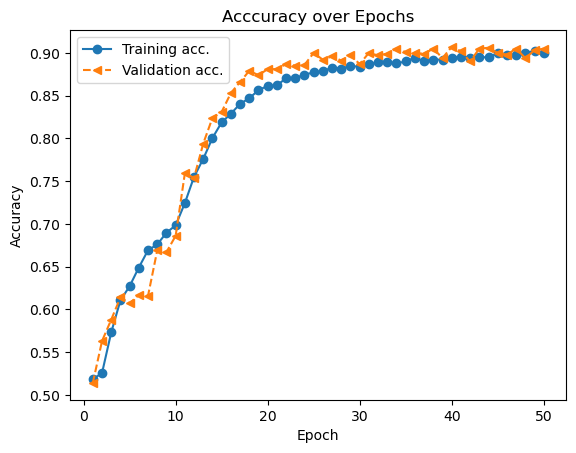

In [37]:
epochs = np.arange(1, num_epochs + 1)

plt.title("Acccuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(epochs, accuracy_hist_train, '-o', label='Training acc.')
plt.plot(epochs, accuracy_hist_valid, '--<', label='Validation acc.')

plt.legend()
plt.savefig('accuracy_over_epochs.png')

In [38]:
test_accuracy = 0.0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred >= .5).float() == y_batch).float().sum()
        test_accuracy += is_correct.item()
test_accuracy /= len(test_dl.dataset)
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.9148
